In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier

import ds_functions as ds
import statistics 

register_matplotlib_converters()

# Heart failure data
hf_data = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')
hf_data_raw = hf_data.copy()

hf_data['sex'] = hf_data['sex'].astype('category')
for c in ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']:
    hf_data[c] = hf_data[c].astype('bool')

hf_data['sex'] = hf_data['sex'].map({1: 'Male', 0: 'Female'})

# Toxicity data
t_data = pd.read_csv('data/qsar_oral_toxicity.csv', sep=';', header=None)
t_data.rename(columns={1024: 'toxic'}, inplace=True)
t_data_raw = t_data.copy()

for c in t_data.columns[:-1]:
    t_data[c] = t_data[c].astype('bool')
t_data[t_data.columns[-1]] = t_data[t_data.columns[-1]].astype('category')
t_data['toxic'].replace({'positive': True, 'negative': False}, inplace=True)

def get_hf_data(filter_outliers=False, feature_selection=False, scaling="none"):
    data = hf_data_raw.copy()
    if (filter_outliers):
        # creatinine_phosphokinase, outliers above 3000
        data = data[data["creatinine_phosphokinase"] <= 3000]

        # serum_creatinine, outliers above 4
        data = data[data["serum_creatinine"] <= 4]

        # platelets, outliers above 600000
        data = data[data["platelets"] <= 600000]
        
    if (feature_selection):
        data = data.drop(columns=['time'])
        
    df_nr = None
    df_sb = None
    if (scaling != "none"):
        df_nr = pd.DataFrame(data, columns=data.select_dtypes(include=['float64','int64']).columns) 
        df_sb = pd.DataFrame(data, columns=data.select_dtypes(include=['bool']).columns)
        
    if (scaling == "z-score"):
        transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
        norm_data_zscore = pd.DataFrame(transf.transform(df_nr), columns=df_nr.columns)
        data = norm_data_zscore.join(df_sb, how='inner')
        
    if (scaling == "minmax"):
        transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
        norm_data_minmax = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
        data = norm_data_minmax.join(df_sb, how='inner')
 
    return data


def get_t_data(feature_selection=False):
    data = t_data_raw.copy()
    
    def get_redundant_pairs(df):
        cols_to_drop = set()
        for i in range(0, df.shape[1]-1):
            if i in cols_to_drop:
                continue
            for j in range(i+1, df.shape[1]-1):
                if df[i][j] > 0.85:
                    cols_to_drop.add(j)

            return list(cols_to_drop)

    def remove_redundant_variables(df):
        au_corr = df.corr().abs()
        labels_to_drop = get_redundant_pairs(au_corr)
        return df.copy().drop(columns=labels_to_drop)

    if (feature_selection):
        data = remove_redundant_variables(data)
        
    return data

In [28]:
def KFold(X, y, nfolds, try_params, seed=None):
    skf = StratifiedKFold(n_splits=nfolds, random_state=seed)

    opts=()
    accuracy = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        scores = [try_params(X_train, X_test, y_train, y_test)]
    
    avg = calculate_avg_results(scores)
    return avg

def calculate_avg_results(results):
    metrics = ['Accuracy', 'Recall', 'Specificity', 'Precision']
    res = {}
    for metric in metrics:
        for params in results[0]:
            if params not in res:
                res[params] = {}
            res[params][metric] = [statistics.mean([fold[params][metric][0] for fold in results]), 
                          statistics.mean([fold[params][metric][1] for fold in results])]
    #print(res)
    return res
    
    

def DecisionTreeTryParams(X_train, X_test, y_train, y_test):
    min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
    max_depths = [2, 5, 10, 15, 20, 25]
    criteria = ['entropy', 'gini']

    results = {}
    for k in range(len(criteria)):
        f = criteria[k]
        for d in max_depths:
            for imp in min_impurity_decrease:
                tree = DecisionTreeClassifier(max_depth=d, criterion=f, min_impurity_decrease=imp)
                tree.fit(X_train, y_train)
                prd_trn = tree.predict(X_train)
                prd_tst = tree.predict(X_test)

                results[(f, d, imp)] = ds.calc_evaluations_results(pd.unique(y), y_train, prd_trn, y_test, prd_tst)

    return results

In [33]:
import numpy as np

df = get_hf_data()
y: np.ndarray = df.pop('DEATH_EVENT').values
X: np.ndarray = df.values
labels = pd.unique(y)
results = KFold(X, y, 5, DecisionTreeTryParams)
best = [params for params in results if 
        all(results[params]['Accuracy'][1] >= results[x]['Accuracy'][1] for x in results)][0]

print(f'{best}: {results[best]}')

('entropy', 5, 0.0025): {'Accuracy': [0.9541666666666667, 0.711864406779661], 'Recall': [0.9877300613496932, 1.0], 'Specificity': [0.8831168831168831, 0.10526315789473684], 'Precision': [0.9470588235294117, 0.7017543859649122]}


TypeError: 'AxesSubplot' object does not support indexing

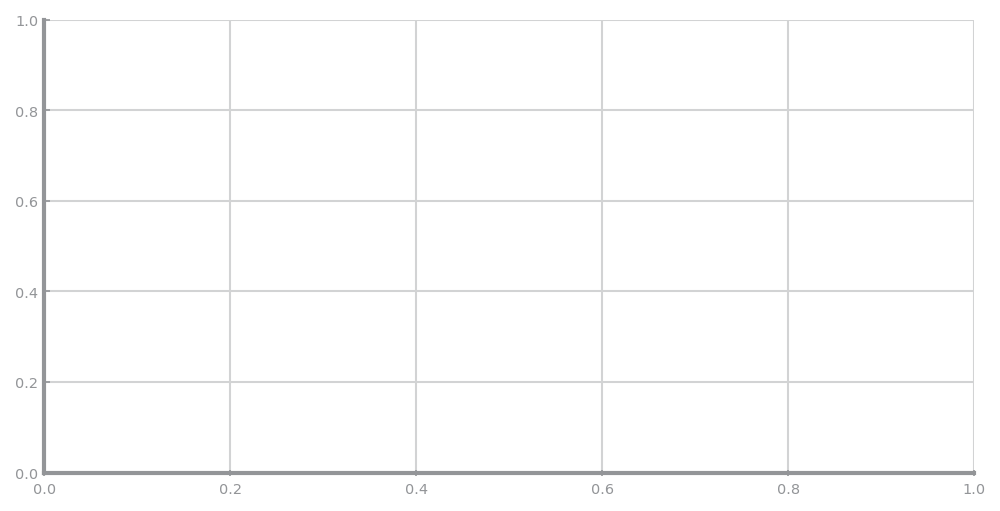

In [1]:
from strategiesavg import *
from data import *

DecisionTreesKFold(get_hf_data(), 'DEATH_EVENT', balancing=None)
